In [1]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 79.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.1/947.1 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.4 MB/s eta 0:00:00


In [2]:
import torch
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.data import Data

/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/libpyg.so: undefined symbol: _ZN3c1010Dispatcher17runRecordFunctionERN2at14RecordFunctionESt17reference_wrapperIKNS_14FunctionSchemaEENS_11DispatchKeyE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_clu

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
data = pd.read_csv("omnipath.csv")

data = data.iloc[:, [1, 2, 3,4]]

node_encoder = LabelEncoder()

nodes = pd.concat([data['from'], data['to']]).unique()
node_encoder.fit(nodes)

data['from_encoded'] = node_encoder.transform(data['from'])
data['to_encoded'] = node_encoder.transform(data['to'])

In [33]:
edge_index = torch.tensor([data['from_encoded'].values, data['to_encoded'].values], dtype=torch.long)
edge_attr = torch.tensor(data['sign'].values, dtype=torch.float).unsqueeze(1)  # Edge Shape: (num_edges, 1)

num_nodes = max(data['from_encoded'].max(), data['to_encoded'].max()) + 1  # Unique nodes
node_features = torch.rand((num_nodes, 32), dtype=torch.float)  # Node feature Shape: (num_nodes, 32)

# PyG Data object
data_py = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)

In [34]:
from torch_geometric.data import Data, HeteroData

#Setting up the heterogeneous graph by including the edge_type (i.e post_translational, transcriptional)

edge_type = data['type'].map({'post_translational': 0, 'transcriptional': 1}).values
edge_type = torch.tensor(edge_type, dtype=torch.long)

node_type = torch.zeros(num_nodes, dtype=torch.long)

node_type_names = ['node']
edge_type_names = [('node', 'post_translational', 'node'), ('node', 'transcriptional', 'node')]

# Converting
hetero_data = data_py.to_heterogeneous(
    node_type=node_type,
    edge_type=edge_type,
    node_type_names=node_type_names,
    edge_type_names=edge_type_names
)

print(hetero_data)

HeteroData(
  node={ x=[9898, 32] },
  (node, post_translational, node)={
    edge_index=[2, 71450],
    edge_attr=[71450, 1],
  },
  (node, transcriptional, node)={
    edge_index=[2, 53982],
    edge_attr=[53982, 1],
  }
)


In [35]:
from torch_geometric.transforms import RandomLinkSplit

transform = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    is_undirected=False,
    add_negative_train_samples=True,
    neg_sampling_ratio=1.0,
    edge_types=[('node', 'post_translational', 'node'), ('node', 'transcriptional', 'node')],
    split_labels=['train', 'valid', 'test']
)

In [36]:
train_data, val_data, test_data = transform(hetero_data)

In [37]:
train_data

HeteroData(
  node={ x=[9898, 32] },
  (node, post_translational, node)={
    edge_index=[2, 57160],
    edge_attr=[57160, 1],
    pos_edge_label=[57160],
    pos_edge_label_index=[2, 57160],
    neg_edge_label=[57160],
    neg_edge_label_index=[2, 57160],
  },
  (node, transcriptional, node)={
    edge_index=[2, 43186],
    edge_attr=[43186, 1],
    pos_edge_label=[43186],
    pos_edge_label_index=[2, 43186],
    neg_edge_label=[43186],
    neg_edge_label_index=[2, 43186],
  }
)

In [18]:
import torch
from torch_geometric.nn import GCNConv

class HeteroGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(HeteroGCNEncoder, self).__init__()


        # Setting up GCNConv layers for each edge type (post_translational and transcriptional)
        self.conv1_post = GCNConv(in_channels, 2 * out_channels)
        self.conv2_post = GCNConv(2 * out_channels, 2 *out_channels)
        self.conv3_post = GCNConv(2 * out_channels, out_channels)

        self.conv1_trans = GCNConv(in_channels, 2 * out_channels)
        self.conv2_trans = GCNConv(2 * out_channels,2* out_channels)
        self.conv3_trans = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index_dict, edge_attr_dict):
        # post_translational edges
        x_post = self.conv1_post(x, edge_index_dict[('node', 'post_translational', 'node')],
                                 edge_weight=edge_attr_dict[('node', 'post_translational', 'node')]).relu()
        x_post = self.conv2_post(x_post, edge_index_dict[('node', 'post_translational', 'node')],
                                 edge_weight=edge_attr_dict[('node', 'post_translational', 'node')]).relu()
        x_post = self.conv3_post(x_post, edge_index_dict[('node', 'post_translational', 'node')],
                                 edge_weight=edge_attr_dict[('node', 'post_translational', 'node')])


        # transcriptional edges
        x_trans = self.conv1_trans(x, edge_index_dict[('node', 'transcriptional', 'node')],
                                   edge_weight=edge_attr_dict[('node', 'transcriptional', 'node')]).relu()
        x_trans = self.conv2_trans(x_trans, edge_index_dict[('node', 'transcriptional', 'node')],
                                   edge_weight=edge_attr_dict[('node', 'transcriptional', 'node')]).relu()
        x_trans = self.conv3_trans(x_trans, edge_index_dict[('node', 'transcriptional', 'node')],
                                   edge_weight=edge_attr_dict[('node', 'transcriptional', 'node')])

        # sum for the 2 edge types
        x_final = x_post + x_trans

        return x_final


In [19]:
from torch_geometric.nn import GAE

out_channels = 31
num_features = train_data['node'].x.shape[1] #64
epochs = 500

# model
model = GAE(HeteroGCNEncoder(num_features, out_channels))


# move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = hetero_data['node'].x.to(device)


#Getting the data in the right format for each of the split
train_pos_edge_index = {
    edge_type: train_data[edge_type].pos_edge_label_index.to(device)
    for edge_type in train_data.edge_types
}

train_pos_edge_attr = {
    edge_type: ((train_data[edge_type].edge_attr.float() + 1)/2).to(device)
    for edge_type in train_data.edge_types
}


val_pos_edge_index = {
    edge_type: val_data[edge_type].pos_edge_label_index.to(device)
    for edge_type in val_data.edge_types
}

val_neg_edge_index = {
    edge_type: val_data[edge_type].neg_edge_label_index.to(device)
    for edge_type in val_data.edge_types
}

test_pos_edge_index = {
    edge_type: test_data[edge_type].pos_edge_label_index.to(device)
    for edge_type in test_data.edge_types
}

test_neg_edge_index = {
    edge_type: test_data[edge_type].neg_edge_label_index.to(device)
    for edge_type in test_data.edge_types
}

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0076774009767145044)

In [20]:
def train():
    model.train()
    optimizer.zero_grad()

    edge_attr_post = train_pos_edge_attr[('node', 'post_translational', 'node')].squeeze(-1) #to convert to 1D
    edge_attr_trans = train_pos_edge_attr[('node', 'transcriptional', 'node')].squeeze(-1)

    #extracting the 2 edge types in the right format needed for model.encode()
    edge_index_dict = {
        ('node', 'post_translational', 'node'): train_pos_edge_index[('node', 'post_translational', 'node')],
        ('node', 'transcriptional', 'node'): train_pos_edge_index[('node', 'transcriptional', 'node')]
    }

    edge_attr_dict = {
        ('node', 'post_translational', 'node'): edge_attr_post,
        ('node', 'transcriptional', 'node'): edge_attr_trans
    }

    z = model.encode(x, edge_index_dict, edge_attr_dict)

    #calculating reconstruction loss seperately for each edge type
    loss_post = model.recon_loss(z, train_pos_edge_index[('node', 'post_translational', 'node')])
    loss_trans = model.recon_loss(z, train_pos_edge_index[('node', 'transcriptional', 'node')])
    loss = loss_post + loss_trans

    loss.backward()
    optimizer.step()

    loss_post_2 = model.recon_loss(z, val_pos_edge_index[('node', 'post_translational', 'node')])
    loss_trans_2 = model.recon_loss(z, val_pos_edge_index[('node', 'transcriptional', 'node')])

    loss2 = loss_post_2 + loss_trans_2

    return float(loss), float(loss2)

In [21]:
def val():
    model.eval()
    edge_attr_post = train_pos_edge_attr[('node', 'post_translational', 'node')].squeeze(-1)
    edge_attr_trans = train_pos_edge_attr[('node', 'transcriptional', 'node')].squeeze(-1)

    edge_index_dict = {
        ('node', 'post_translational', 'node'): train_pos_edge_index[('node', 'post_translational', 'node')],
        ('node', 'transcriptional', 'node'): train_pos_edge_index[('node', 'transcriptional', 'node')]
    }

    edge_attr_dict = {
        ('node', 'post_translational', 'node'): edge_attr_post,
        ('node', 'transcriptional', 'node'): edge_attr_trans
    }

    with torch.no_grad():
        z = model.encode(x, edge_index_dict, edge_attr_dict)
        sum_1 = model.test(z, val_pos_edge_index[('node', 'post_translational', 'node')], val_neg_edge_index[('node', 'post_translational', 'node')])
        sum_2 = model.test(z, val_pos_edge_index[('node', 'transcriptional', 'node')], val_neg_edge_index[('node', 'transcriptional', 'node')])

    return sum_1[0] + sum_2[0], sum_1[1] + sum_2[1] #we are summing the AUC and AP score for both the edge type and returning that value

In [22]:
def test(model_best):
    model_best.eval()
    edge_attr_post = train_pos_edge_attr[('node', 'post_translational', 'node')].squeeze(-1)
    edge_attr_trans = train_pos_edge_attr[('node', 'transcriptional', 'node')].squeeze(-1)

    edge_index_dict = {
        ('node', 'post_translational', 'node'): train_pos_edge_index[('node', 'post_translational', 'node')],
        ('node', 'transcriptional', 'node'): train_pos_edge_index[('node', 'transcriptional', 'node')]
    }

    edge_attr_dict = {
        ('node', 'post_translational', 'node'): edge_attr_post,
        ('node', 'transcriptional', 'node'): edge_attr_trans
    }
    results = {}
    with torch.no_grad():
        z = model_best.encode(x, edge_index_dict, edge_attr_dict)

        #looping through the 2 edge types
        for edge_type in test_pos_edge_index.keys():
            pos_edge_index = test_pos_edge_index[edge_type]
            neg_edge_index = test_neg_edge_index[edge_type]

            pos_prob = model_best.decode(z, pos_edge_index)
            neg_prob = model_best.decode(z, neg_edge_index)

            results[edge_type] = {
                'pos_prob': pos_prob,
                'neg_prob': neg_prob
            }

    return results

In [23]:
import copy

best_val_auc = 0
best_model = None

a = [] #train loss
b = [] #val_auc
c = [] #val_ap
d = [] #val loss

for epoch in range(1, epochs + 1):
    loss, loss2 = train()
    a.append(loss)
    d.append(loss2)

    # Evaluate on validation set
    val_auc, val_ap = val()
    print('Epoch: {:03d}, Loss: {:.4f}, Val AUC: {:.4f}, Val AP: {:.4f}'.format(epoch, loss, val_auc, val_ap))
    b.append(val_auc)
    c.append(val_ap)

    # Saving the best model based on validation performance and to prevent overfitting
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model = copy.deepcopy(model)

Epoch: 001, Loss: 26.9302, Val AUC: 1.6092, Val AP: 1.5780
Epoch: 002, Loss: 5.1053, Val AUC: 1.5008, Val AP: 1.4946
Epoch: 003, Loss: 3.5945, Val AUC: 1.6788, Val AP: 1.6180
Epoch: 004, Loss: 3.3196, Val AUC: 1.6775, Val AP: 1.6151
Epoch: 005, Loss: 2.8966, Val AUC: 1.6755, Val AP: 1.6211
Epoch: 006, Loss: 2.6708, Val AUC: 1.6709, Val AP: 1.6268
Epoch: 007, Loss: 2.5763, Val AUC: 1.6734, Val AP: 1.6318
Epoch: 008, Loss: 2.5491, Val AUC: 1.6808, Val AP: 1.6369
Epoch: 009, Loss: 2.5412, Val AUC: 1.6856, Val AP: 1.6405
Epoch: 010, Loss: 2.5326, Val AUC: 1.6917, Val AP: 1.6423
Epoch: 011, Loss: 2.5252, Val AUC: 1.6989, Val AP: 1.6424
Epoch: 012, Loss: 2.5233, Val AUC: 1.7041, Val AP: 1.6446
Epoch: 013, Loss: 2.5172, Val AUC: 1.7076, Val AP: 1.6486
Epoch: 014, Loss: 2.5130, Val AUC: 1.7102, Val AP: 1.6524
Epoch: 015, Loss: 2.5084, Val AUC: 1.7122, Val AP: 1.6563
Epoch: 016, Loss: 2.4981, Val AUC: 1.7132, Val AP: 1.6582
Epoch: 017, Loss: 2.4940, Val AUC: 1.7125, Val AP: 1.6598
Epoch: 018, L

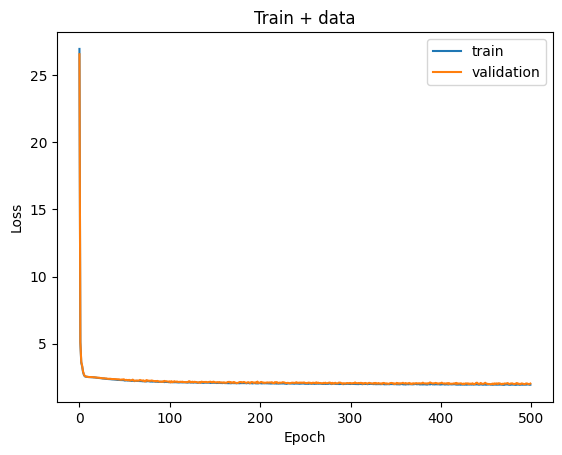

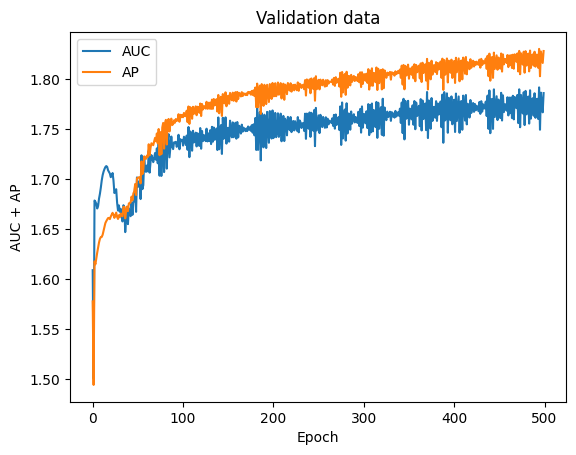

In [24]:
import matplotlib.pyplot as plt

plt.plot(a)
plt.plot(d)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train","validation"])
plt.title("Train + data")
plt.show()

plt.plot(b)
plt.plot(c)
plt.xlabel("Epoch")
plt.ylabel("AUC + AP")
plt.title("Validation data")
plt.legend(["AUC","AP"])
plt.show()

In [25]:
model_final_gae = best_model
final_prob = test(model_final_gae)

In [32]:
final_len_post = final_prob[('node', 'post_translational', 'node')]["pos_prob"].shape
percentage_post = (final_prob[('node', 'post_translational', 'node')]["pos_prob"] >= 0.7).sum()

final_len_trans = final_prob[('node', 'transcriptional', 'node')]["pos_prob"].shape
percentage_trans = (final_prob[('node', 'transcriptional', 'node')]["pos_prob"] >= 0.7).sum()

percentage = (percentage_post + percentage_trans) / (final_len_post[0] + final_len_trans[0])

print(f"{percentage * 100:.2f}% links predicted positive")

79.55% links predicted positive


VGAE

In [38]:
class HeteroVGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(HeteroVGCNEncoder, self).__init__()


        self.conv1_post = GCNConv(in_channels, 2 * out_channels)
        self.conv2_post = GCNConv(2 * out_channels, 2 * out_channels)

        self.conv_mu_post = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd_post = GCNConv(2 * out_channels, out_channels, cached=True)

        self.conv1_trans = GCNConv(in_channels, 2 * out_channels)
        self.conv2_trans = GCNConv(2 * out_channels,2* out_channels)

        self.conv_mu_trans = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd_trans = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index_dict, edge_attr_dict):
        # post_translational edges
        x_post = self.conv1_post(x, edge_index_dict[('node', 'post_translational', 'node')],
                                 edge_weight=edge_attr_dict[('node', 'post_translational', 'node')]).relu()
        x_post = self.conv2_post(x_post, edge_index_dict[('node', 'post_translational', 'node')],
                                 edge_weight=edge_attr_dict[('node', 'post_translational', 'node')])

        # transcriptional edges
        x_trans = self.conv1_trans(x, edge_index_dict[('node', 'transcriptional', 'node')],
                                   edge_weight=edge_attr_dict[('node', 'transcriptional', 'node')]).relu()
        x_trans = self.conv2_trans(x_trans, edge_index_dict[('node', 'transcriptional', 'node')],
                                   edge_weight=edge_attr_dict[('node', 'transcriptional', 'node')])

        mu_post = self.conv_mu_post(x_post, edge_index_dict[('node', 'post_translational', 'node')],
                                    edge_weight=edge_attr_dict[('node', 'post_translational', 'node')])
        logstd_post = self.conv_logstd_post(x_post, edge_index_dict[('node', 'post_translational', 'node')],
                                            edge_weight=edge_attr_dict[('node', 'post_translational', 'node')])

        mu_trans = self.conv_mu_trans(x_trans, edge_index_dict[('node', 'transcriptional', 'node')],
                                      edge_weight=edge_attr_dict[('node', 'transcriptional', 'node')])
        logstd_trans = self.conv_logstd_trans(x_trans, edge_index_dict[('node', 'transcriptional', 'node')],
                                              edge_weight=edge_attr_dict[('node', 'transcriptional', 'node')])

        # Sum of the mu and logstd for the 2 edge types
        mu = mu_post + mu_trans
        logstd = logstd_post + logstd_trans

        return mu, logstd

In [39]:
from torch_geometric.nn import VGAE


out_channels = 42
num_features = data_py.x.shape[1] # 32
epochs = 500

# model
model = VGAE(HeteroVGCNEncoder(num_features, out_channels))



# move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = hetero_data['node'].x.to(device)


#Getting the data in the right format for each of the split

train_pos_edge_index = {
    edge_type: train_data[edge_type].pos_edge_label_index.to(device)
    for edge_type in train_data.edge_types
}

train_pos_edge_attr = {
    edge_type: ((train_data[edge_type].edge_attr.float() + 1)/2).to(device)
    for edge_type in train_data.edge_types
}


val_pos_edge_index = {
    edge_type: val_data[edge_type].pos_edge_label_index.to(device)
    for edge_type in val_data.edge_types
}

val_neg_edge_index = {
    edge_type: val_data[edge_type].neg_edge_label_index.to(device)
    for edge_type in val_data.edge_types
}

test_pos_edge_index = {
    edge_type: test_data[edge_type].pos_edge_label_index.to(device)
    for edge_type in test_data.edge_types
}

test_neg_edge_index = {
    edge_type: test_data[edge_type].neg_edge_label_index.to(device)
    for edge_type in test_data.edge_types
}

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.009936477241185999)

In [40]:
def train_2():
    model.train()
    optimizer.zero_grad()

    edge_attr_post = train_pos_edge_attr[('node', 'post_translational', 'node')].squeeze(-1)
    edge_attr_trans = train_pos_edge_attr[('node', 'transcriptional', 'node')].squeeze(-1)

    edge_index_dict = {
        ('node', 'post_translational', 'node'): train_pos_edge_index[('node', 'post_translational', 'node')],
        ('node', 'transcriptional', 'node'): train_pos_edge_index[('node', 'transcriptional', 'node')]
    }

    edge_attr_dict = {
        ('node', 'post_translational', 'node'): edge_attr_post,
        ('node', 'transcriptional', 'node'): edge_attr_trans
    }
    z = model.encode(x, edge_index_dict, edge_attr_dict)

    loss_post = model.recon_loss(z, train_pos_edge_index[('node', 'post_translational', 'node')])
    loss_trans = model.recon_loss(z, train_pos_edge_index[('node', 'transcriptional', 'node')])
    loss_1 = loss_post + loss_trans

    kl_loss = (1 / hetero_data['node'].x.shape[0]) * model.kl_loss()

    loss = loss_1 + kl_loss

    loss.backward()
    optimizer.step()

    loss_post_2 = model.recon_loss(z, val_pos_edge_index[('node', 'post_translational', 'node')])
    loss_trans_2 = model.recon_loss(z, val_pos_edge_index[('node', 'transcriptional', 'node')])

    loss2 = loss_post_2 + loss_trans_2

    return float(loss), float(loss2)

In [50]:
best_val_auc = 0
best_model = None

a = [] #train loss
b = [] #val_auc
c = [] #val_ap
d = [] #val loss

for epoch in range(1, epochs + 1):
    loss, loss2 = train_2()
    a.append(loss)
    d.append(loss2)

    # Evaluate on validation set
    val_auc, val_ap = val()
    print('Epoch: {:03d}, Loss: {:.4f}, Val AUC: {:.4f}, Val AP: {:.4f}'.format(epoch, loss, val_auc, val_ap))
    b.append(val_auc)
    c.append(val_ap)

    # Saving the best model based on validation performance and to prevent overfitting
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model = copy.deepcopy(model)

Epoch: 001, Loss: 2.0492, Val AUC: 1.7738, Val AP: 1.8101
Epoch: 002, Loss: 2.0437, Val AUC: 1.7541, Val AP: 1.7990
Epoch: 003, Loss: 2.0224, Val AUC: 1.7664, Val AP: 1.8059
Epoch: 004, Loss: 2.0208, Val AUC: 1.7591, Val AP: 1.8025
Epoch: 005, Loss: 2.0263, Val AUC: 1.7648, Val AP: 1.8057
Epoch: 006, Loss: 2.0247, Val AUC: 1.7622, Val AP: 1.8039
Epoch: 007, Loss: 2.0305, Val AUC: 1.7572, Val AP: 1.8015
Epoch: 008, Loss: 2.0365, Val AUC: 1.7652, Val AP: 1.8056
Epoch: 009, Loss: 2.0509, Val AUC: 1.7561, Val AP: 1.8004
Epoch: 010, Loss: 2.0337, Val AUC: 1.7700, Val AP: 1.8081
Epoch: 011, Loss: 2.0400, Val AUC: 1.7427, Val AP: 1.7906
Epoch: 012, Loss: 2.0434, Val AUC: 1.7798, Val AP: 1.8115
Epoch: 013, Loss: 2.0427, Val AUC: 1.7167, Val AP: 1.7665
Epoch: 014, Loss: 2.0887, Val AUC: 1.7906, Val AP: 1.8073
Epoch: 015, Loss: 2.1201, Val AUC: 1.6639, Val AP: 1.7135
Epoch: 016, Loss: 2.1948, Val AUC: 1.7890, Val AP: 1.8077
Epoch: 017, Loss: 2.1039, Val AUC: 1.7457, Val AP: 1.7918
Epoch: 018, Lo

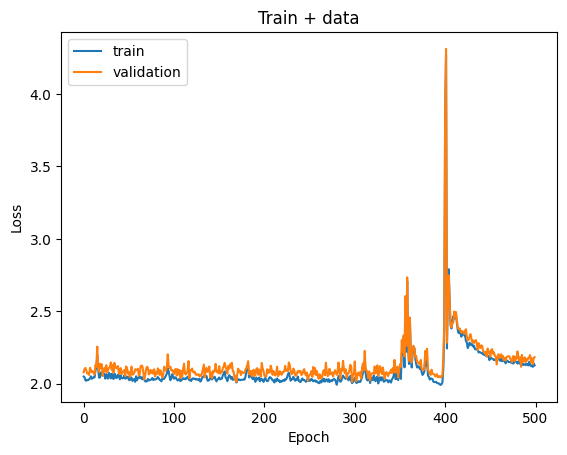

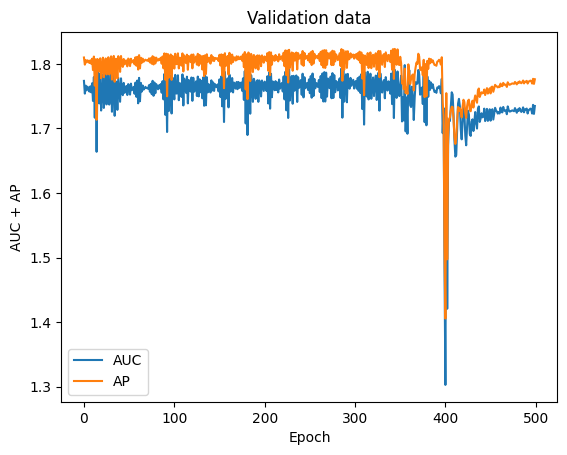

In [51]:
plt.plot(a)
plt.plot(d)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train","validation"])
plt.title("Train + data")
plt.show()

plt.plot(b)
plt.plot(c)
plt.xlabel("Epoch")
plt.ylabel("AUC + AP")
plt.title("Validation data")
plt.legend(["AUC","AP"])
plt.show()

In [52]:
model_final_vgae = best_model
final_prob = test(model_final_vgae)

In [59]:
final_len_post = final_prob[('node', 'post_translational', 'node')]["pos_prob"].shape
percentage_post = (final_prob[('node', 'post_translational', 'node')]["pos_prob"] >= 0.7).sum()

final_len_trans = final_prob[('node', 'transcriptional', 'node')]["pos_prob"].shape
percentage_trans = (final_prob[('node', 'transcriptional', 'node')]["pos_prob"] >= 0.7).sum()

percentage = (percentage_post + percentage_trans) / (final_len_post[0] + final_len_trans[0])

print(f"{percentage * 100:.2f}% links predicted positive")

86.09% links predicted positive
